In [1]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver
import math

In [2]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [3]:
properties = driver.active.utils.get_device_properties(DEVICE.index)

In [4]:
properties

{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 64,
 'warpSize': 32,
 'sm_clock_rate': 1695000,
 'mem_clock_rate': 8001000,
 'mem_bus_width': 384}

In [5]:
@triton.jit
def apply_rope_kernel(
    Q_ptr, K_ptr, cos_ptr, sin_ptr, pos_ids_ptr,
    Q_out_ptr, K_out_ptr,
    seq_len, num_heads, head_dim,
    batch_stride, seq_stride, head_stride,
    BLOCK_SIZE: tl.constexpr,
    DTYPE: tl.constexpr,
):
    # Identify which batch, sequence position, and head this program handles
    pid_batch = tl.program_id(0)  # Batch index
    pid_seq = tl.program_id(1)    # Sequence position
    pid_head = tl.program_id(2)   # Head index
    
    # Get position ID for this sequence position
    pos_id = tl.load(pos_ids_ptr + pid_batch * seq_len + pid_seq)
    
    # Calculate base pointer offset for Q and K
    base_offset = (pid_batch * batch_stride + 
                   pid_seq * seq_stride + 
                   pid_head * head_stride)
    
    Q_start_ptr = Q_ptr + base_offset
    K_start_ptr = K_ptr + base_offset
    Q_out_start_ptr = Q_out_ptr + base_offset
    K_out_start_ptr = K_out_ptr + base_offset
    
    # Process the head dimension in chunks
    for k in range(0, tl.cdiv(head_dim, BLOCK_SIZE*2)):
        # Calculate offsets for even elements (0, 2, 4, ...)
        even_offsets = k * (BLOCK_SIZE*2) + tl.arange(0, BLOCK_SIZE) * 2
        even_mask = even_offsets < head_dim
        
        # Calculate offsets for odd elements (1, 3, 5, ...)
        odd_offsets = even_offsets + 1
        odd_mask = odd_offsets < head_dim
        
        # Load even and odd elements separately
        q_even = tl.load(Q_start_ptr + even_offsets, mask=even_mask)
        q_odd = tl.load(Q_start_ptr + odd_offsets, mask=odd_mask)
        k_even = tl.load(K_start_ptr + even_offsets, mask=even_mask)
        k_odd = tl.load(K_start_ptr + odd_offsets, mask=odd_mask)
        
        # Load cos/sin values (one per pair)
        cos_offsets = k * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
        cos_mask = cos_offsets < (head_dim // 2)
        cos_vals = tl.load(cos_ptr + pos_id * (head_dim//2) + cos_offsets, mask=cos_mask)
        sin_vals = tl.load(sin_ptr + pos_id * (head_dim//2) + cos_offsets, mask=cos_mask)
        
        # Apply rotation
        q_even_out = q_even * cos_vals - q_odd * sin_vals
        q_odd_out = q_odd * cos_vals + q_even * sin_vals
        k_even_out = k_even * cos_vals - k_odd * sin_vals
        k_odd_out = k_odd * cos_vals + k_even * sin_vals
        
        # Store results
        tl.store(Q_out_start_ptr + even_offsets, q_even_out, mask=even_mask)
        tl.store(Q_out_start_ptr + odd_offsets, q_odd_out, mask=odd_mask)
        tl.store(K_out_start_ptr + even_offsets, k_even_out, mask=even_mask)
        tl.store(K_out_start_ptr + odd_offsets, k_odd_out, mask=odd_mask)

In [6]:
def apply_rope(q: torch.Tensor, k: torch.Tensor, pos_ids: torch.Tensor, cosines: torch.Tensor, sines: torch.Tensor):
    q_out = torch.zeros_like(q)
    k_out = torch.zeros_like(k)
    B, L, H, D = q.shape
    num_stages = 8
    BLOCK_SIZE = 32
    
    # Grid dimensions should be (batch, sequence_length, num_heads)
    grid = (B, L, H)
    
    apply_rope_kernel[grid](
        q, k, cosines, sines, pos_ids,  # Input tensors
        q_out, k_out,                   # Output tensors
        L, H, D,                        # Dimensions
        q.stride(0), q.stride(1), q.stride(2),  # Strides
        BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages,
        DTYPE=tl.float32
    )
    
    return q_out, k_out

In [7]:
# For comparing with native PyTorch implementation
def torch_apply_rope(q, k, position_ids, head_dim):
    # Create position embeddings
    inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2, device=q.device).float() / head_dim))
    
    # Get sin and cos values
    batch_size, seq_len = position_ids.shape
    freqs = torch.einsum("b l, d -> b l d", position_ids.float(), inv_freq)
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos()[:, :, None, :].repeat(1, 1, q.shape[2], 1)
    sin = emb.sin()[:, :, None, :].repeat(1, 1, q.shape[2], 1)
    
    q_even = q[..., ::2]
    q_odd = q[..., 1::2]
    k_even = k[..., ::2]
    k_odd = k[..., 1::2]

    q_even_out = q_even * cos[..., :head_dim//2] - q_odd * sin[..., :head_dim//2]
    q_odd_out = q_odd * cos[..., :head_dim//2] + q_even * sin[..., :head_dim//2]
    k_even_out = k_even * cos[..., :head_dim//2] - k_odd * sin[..., :head_dim//2]
    k_odd_out = k_odd * cos[..., :head_dim//2] + k_even * sin[..., :head_dim//2]

    # Recombine
    q_out = torch.zeros_like(q)
    k_out = torch.zeros_like(k)
    q_out[..., ::2] = q_even_out
    q_out[..., 1::2] = q_odd_out
    k_out[..., ::2] = k_even_out
    k_out[..., 1::2] = k_odd_out
    
    return q_out, k_out

# Test function
def test_apply_rope():
    # Set up test data
    torch.manual_seed(0)
    device = torch.device('cuda')
    
    # Parameters
    batch_size = 2
    seq_len = 16
    num_heads = 4
    head_dim = 64
    
    # Generate test data
    q = torch.randn((batch_size, seq_len, num_heads, head_dim), device=device, dtype=torch.float32)
    k = torch.randn((batch_size, seq_len, num_heads, head_dim), device=device, dtype=torch.float32)
    
    # Position IDs
    position_ids = torch.arange(seq_len, device=device).unsqueeze(0).repeat(batch_size, 1)
    
    # Precompute cosines and sines
    inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2, device=device).float() / head_dim))
    
    # Initialize cosine and sine tables
    cos_table = torch.zeros((seq_len, head_dim // 2), device=device)
    sin_table = torch.zeros((seq_len, head_dim // 2), device=device)
    
    for pos in range(seq_len):
        freqs = pos * inv_freq
        cos_table[pos] = freqs.cos()
        sin_table[pos] = freqs.sin()
    
    # Run your Triton version
    triton_q_out, triton_k_out = apply_rope(q, k, position_ids, cos_table, sin_table)
    
    # Run PyTorch reference
    torch_q_out, torch_k_out = torch_apply_rope(q, k, position_ids, head_dim)
    
    # Compare results
    q_match = torch.allclose(triton_q_out, torch_q_out, atol=1e-5, rtol=1e-5)
    k_match = torch.allclose(triton_k_out, torch_k_out, atol=1e-5, rtol=1e-5)
    
    if q_match and k_match:
        print("✅ Triton and Torch RoPE implementations match")
    else:
        print("❌ Triton and Torch RoPE implementations differ")
        if not q_match:
            print(f"Q max difference: {(triton_q_out - torch_q_out).abs().max().item()}")
        if not k_match:
            print(f"K max difference: {(triton_k_out - torch_k_out).abs().max().item()}")

# Run the test
test_apply_rope()

✅ Triton and Torch RoPE implementations match


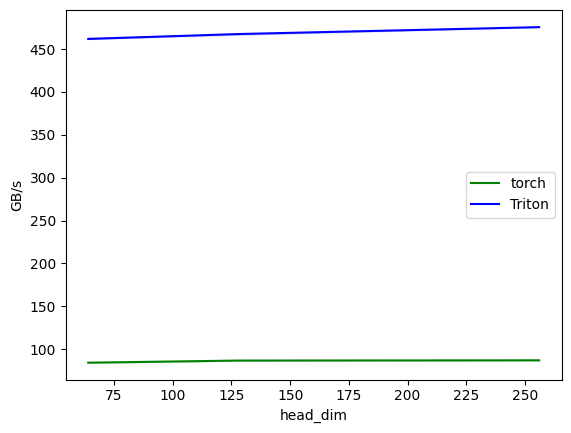

rope-performance-seq128-fp32:
   head_dim      torch      Triton
0      64.0  84.321545  461.690126
1     128.0  86.800399  467.422441
2     256.0  87.086015  475.459648


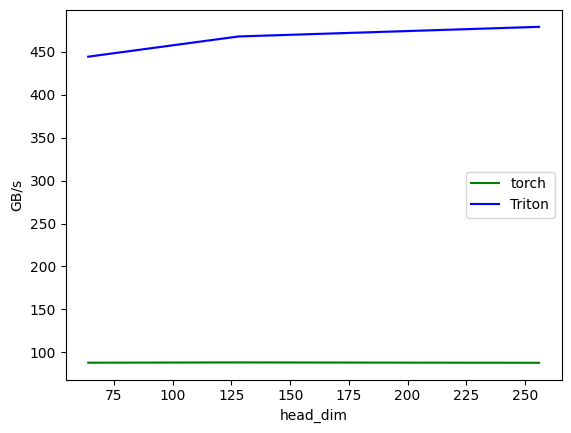

rope-performance-seq512-fp32:
   head_dim      torch      Triton
0      64.0  87.896765  444.474568
1     128.0  88.238917  468.048179
2     256.0  87.791249  479.261591


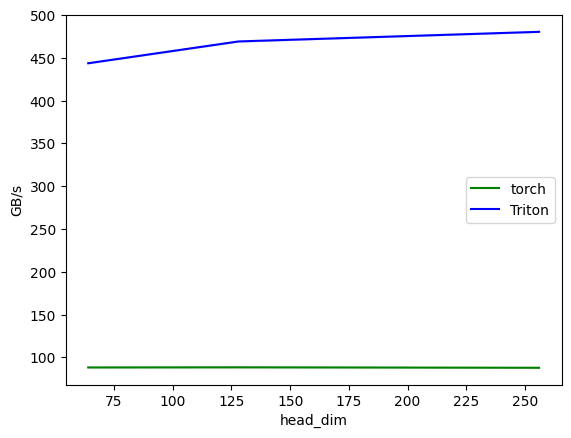

rope-performance-seq1024-fp32:
   head_dim      torch      Triton
0      64.0  88.340916  443.722491
1     128.0  88.525636  469.199751
2     256.0  87.956895  480.441593
None


In [10]:
# Configurate the benchmarks
configs = []
ref_lib = "torch"
seq_lengths = [128, 512, 1024]

for seq_len in seq_lengths:
    configs.append(
        triton.testing.Benchmark(
            x_names=["head_dim"],  # Argument names to use as an x-axis for the plot
            x_vals=[64, 128, 256],  # Different possible values for head_dim
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="GB/s",  # Label name for the y-axis
            plot_name=f"rope-performance-seq{seq_len}-fp32",  # Name for the plot
            args={"seq_len": seq_len, "batch_size": 32, "num_heads": 32},
        ))

@triton.testing.perf_report(configs)
def benchmark(head_dim, provider, batch_size, seq_len, num_heads):
    # Generate test data
    q = torch.randn((batch_size, seq_len, num_heads, head_dim), device=DEVICE, dtype=torch.float32)
    k = torch.randn((batch_size, seq_len, num_heads, head_dim), device=DEVICE, dtype=torch.float32)
    
    # Position IDs
    position_ids = torch.arange(seq_len, device=DEVICE).unsqueeze(0).repeat(batch_size, 1)
    
    # Precompute cosines and sines
    inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2, device=DEVICE).float() / head_dim))
    
    # Initialize cosine and sine tables
    cos_table = torch.zeros((seq_len, head_dim // 2), device=DEVICE)
    sin_table = torch.zeros((seq_len, head_dim // 2), device=DEVICE)
    
    for pos in range(seq_len):
        freqs = pos * inv_freq
        cos_table[pos] = freqs.cos()
        sin_table[pos] = freqs.sin()
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch_apply_rope(q, k, position_ids, head_dim=head_dim), 
            quantiles=quantiles
        )
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: apply_rope(q, k, position_ids, cos_table, sin_table),
            quantiles=quantiles
        )
    
    # Calculate memory bandwidth
    # For RoPE:
    # - Read Q and K tensors
    # - Read cosine and sine tables for each position
    # - Write output Q and K tensors
    bytes_per_element = 4  # float32
    
    # Input tensors size: batch_size * seq_len * num_heads * head_dim * 2 (for Q and K)
    input_size = batch_size * seq_len * num_heads * head_dim * 2
    
    # Lookup tables size: seq_len * (head_dim // 2) * 2 (for cos and sin)
    lookup_size = seq_len * (head_dim // 2) * 2
    
    # Position ids size: batch_size * seq_len
    pos_ids_size = batch_size * seq_len
    
    # Output tensors size: same as input
    output_size = input_size
    
    # Total bytes accessed
    bytes_accessed = (input_size + lookup_size + pos_ids_size + output_size) * bytes_per_element
    
    # Convert to GB/s
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

# Run the benchmark
print(benchmark.run(show_plots=True, print_data=True))